VGG16 

In [1]:
import keras
keras.__version__

/home/leechan/anaconda3/envs/DLCNN/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.1.5'

In [2]:
from keras.applications.vgg16 import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/home/leechan/Documents/Capstone_Dog vs. Cats/Project_Dogs_vs_Cats/Dataset_Dogs_vs_Cats/base'
train_dir = os.path.join(base_dir, 'train_dir')
validation_dir = os.path.join(base_dir, 'validation_dir')

test_dir = '/home/leechan/Documents/Capstone_Dog vs. Cats/Project_Dogs_vs_Cats/Dataset_Dogs_vs_Cats/base/test_dir'

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 15

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
            
    return features, labels

def extract_features_test(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode=None)
    i = 0
    for inputs_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        i += 1
        if i * batch_size >= sample_count:
            break
            
    return features

test_features = extract_features_test(test_dir, 12500)
train_features, train_labels = extract_features(train_dir, 20000)
validation_features, validation_labels = extract_features(validation_dir, 5000)

Found 12500 images belonging to 1 classes.
Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [6]:
train_features = np.reshape(train_features, (20000, 7 * 7 * 512))
validation_features = np.reshape(validation_features, (5000, 7 * 7 * 512))
test_features = np.reshape(test_features, (12500, 7 * 7 * 512))

In [7]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=7 * 7 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [8]:
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=120,
                    validation_data=(validation_features, validation_labels))

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 3s 162us/step - loss: 0.3821 - acc: 0.8251 - val_loss: 0.2524 - val_acc: 0.8958
Epoch 2/30
20000/20000 [==============================] - 2s 97us/step - loss: 0.2346 - acc: 0.9031 - val_loss: 0.2034 - val_acc: 0.9192
Epoch 3/30
20000/20000 [==============================] - 2s 96us/step - loss: 0.1963 - acc: 0.9228 - val_loss: 0.2083 - val_acc: 0.9188
Epoch 4/30
20000/20000 [==============================] - 2s 96us/step - loss: 0.1757 - acc: 0.9287 - val_loss: 0.1789 - val_acc: 0.9306
Epoch 5/30
20000/20000 [==============================] - 2s 96us/step - loss: 0.1573 - acc: 0.9382 - val_loss: 0.1800 - val_acc: 0.9254
Epoch 6/30
20000/20000 [==============================] - 2s 96us/step - loss: 0.1468 - acc: 0.9423 - val_loss: 0.1710 - val_acc: 0.9316
Epoch 7/30
20000/20000 [==============================] - 2s 93us/step - loss: 0.1367 - acc: 0.9467 - val_loss: 0.1704 - val_acc

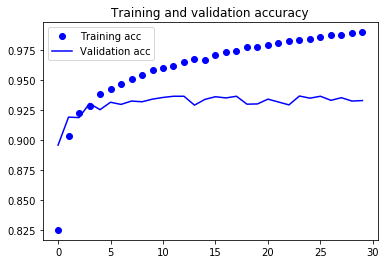

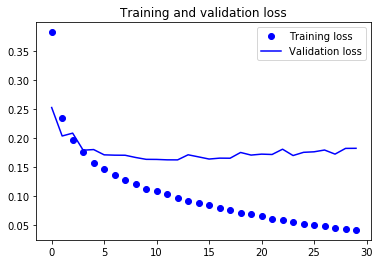

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

just extracte features can only obtain about 93% val acc

In [11]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 21,137,729
Trainable params: 21,137,729
Non-trainable params: 0
_________________________________________________________________


In [13]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [14]:
conv_base.trainable = False

In [15]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


illustrate why use batch size of 100

In [16]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 224x224
        target_size=(224, 224),
        batch_size=100,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=100,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=200,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/50
 - 199s - loss: 0.3776 - acc: 0.8355 - val_loss: 0.2451 - val_acc: 0.9018
Epoch 2/50
 - 185s - loss: 0.2587 - acc: 0.8905 - val_loss: 0.2404 - val_acc: 0.9008
Epoch 3/50
 - 184s - loss: 0.2317 - acc: 0.9037 - val_loss: 0.1914 - val_acc: 0.9246
Epoch 4/50
 - 184s - loss: 0.2155 - acc: 0.9101 - val_loss: 0.2068 - val_acc: 0.9186
Epoch 5/50
 - 184s - loss: 0.2038 - acc: 0.9136 - val_loss: 0.1709 - val_acc: 0.9338
Epoch 6/50
 - 184s - loss: 0.1982 - acc: 0.9176 - val_loss: 0.1734 - val_acc: 0.9332
Epoch 7/50
 - 184s - loss: 0.1892 - acc: 0.9211 - val_loss: 0.1612 - val_acc: 0.9382
Epoch 8/50
 - 185s - loss: 0.1835 - acc: 0.9233 - val_loss: 0.1634 - val_acc: 0.9370
Epoch 9/50
 - 185s - loss: 0.1822 - acc: 0.9252 - val_loss: 0.1597 - val_acc: 0.9386
Epoch 10/50
 - 184s - loss: 0.1824 - acc: 0.9233 - val_loss: 0.1877 - val_acc: 0.9266
Epoch 11/50
 - 184s - loss: 0.1761 - acc: 0.9293 - val_loss: 0.1

In [17]:
model.save('VGG16_top_classifier_training.h5')

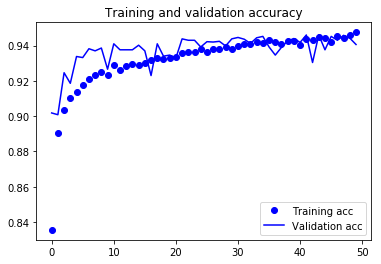

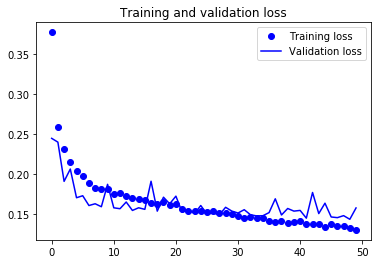

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Fintuning: freezing the last 3 conv layer didn't get very impressive result, so I decide to freezing the last 5 conv and see how well it perform. actually, if the layer is very deep, it should come with more specific feature.

In [20]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block4_conv3':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [21]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',patience=3)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=200,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=[early_stopping])

Epoch 1/50
200/200 [==============================] - 200s 1000ms/step - loss: 0.1404 - acc: 0.9440 - val_loss: 0.1353 - val_acc: 0.9536
Epoch 2/50
200/200 [==============================] - 187s 936ms/step - loss: 0.1007 - acc: 0.9597 - val_loss: 0.1055 - val_acc: 0.9586
Epoch 3/50
200/200 [==============================] - 189s 944ms/step - loss: 0.0843 - acc: 0.9665 - val_loss: 0.1285 - val_acc: 0.9610
Epoch 4/50
200/200 [==============================] - 188s 938ms/step - loss: 0.0758 - acc: 0.9709 - val_loss: 0.1329 - val_acc: 0.9580
Epoch 5/50
200/200 [==============================] - 189s 943ms/step - loss: 0.0660 - acc: 0.9745 - val_loss: 0.0939 - val_acc: 0.9704
Epoch 6/50
200/200 [==============================] - 189s 943ms/step - loss: 0.0568 - acc: 0.9777 - val_loss: 0.0946 - val_acc: 0.9714
Epoch 7/50
200/200 [==============================] - 188s 939ms/step - loss: 0.0542 - acc: 0.9789 - val_loss: 0.0918 - val_acc: 0.9722
Epoch 8/50
200/200 [===========================

In [22]:
model.save('VGG16_finetuning.h5')

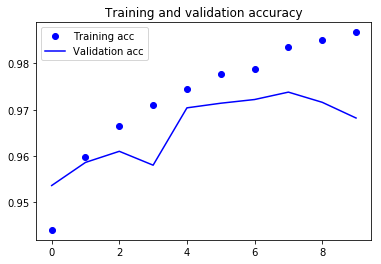

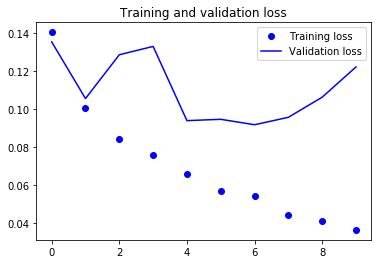

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

shuffle=False is very important, or not when predict generate we can't catch order.

In [85]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=100,
        class_mode=None,
        shuffle=False)

id_batch = test_generator.filenames
print(id_batch[:10])

Found 12500 images belonging to 1 classes.
['test/1.jpg', 'test/10.jpg', 'test/100.jpg', 'test/1000.jpg', 'test/10000.jpg', 'test/10001.jpg', 'test/10002.jpg', 'test/10003.jpg', 'test/10004.jpg', 'test/10005.jpg']


In [86]:
y_pred = model.predict_generator(generator=test_generator,
                                 steps = 125,
                                 workers=1)

In [88]:
y_pred = y_pred.clip(min=0.005, max=0.995)
y_pred = y_pred.reshape(12500,)

In [89]:
from tqdm import tqdm

with open('VGG16_Fintuning.csv','w') as f:
    f.write('id,label\n')
    
with open('VGG16_Fintuning.csv','a') as f:
    i = 0
    for img_label in tqdm(y_pred):
        img_name = id_batch[i]
        img_id = int(img_name[img_name.rfind('/')+1:img_name.rfind('.')])
        f.write('{},{}\n'.format(img_id,img_label))
        i+=1

100%|██████████| 12500/12500 [00:00<00:00, 544217.24it/s]


Score:0.10118
